In [1]:
import os 
import timm
import torch
import torch
import torch.nn as nn
import requests
import timm
import math
from PIL import Image
from torchvision import transforms
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from lightly.data.dataset import LightlyDataset

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [2]:
from multissl.models import MSRGBConvNeXtInstanceSegmentationModule
from multissl.plotting.rgb_batch import rgb_visualize_batch
from multissl.data.instance_segmentation_dataset import COCOInstanceSegmentationDataset, get_instance_transforms, augmented_duplicates_collate_fn

# Segmentation Head Loading

In [3]:

args = {"checkpoint_path":"../checkpoints_convnext_tiny/last.ckpt",
    "num_classes": 2,
    "class_names": ["Background", "Solarpanel"],
    "freeze_backbone": True,
    "batch_size": 4,
    "img_size": 448,

       }
# pretrained tiny has hierarchical fusion: at every layer MS +RGB is fused with attention

pl_model =  MSRGBConvNeXtInstanceSegmentationModule(
        num_classes=args["num_classes"],  # Binary segmentation (background, foreground)
        rgb_in_channels=3,
        ms_in_channels=5,  # Adjust based on your MS data
        model_size='tiny',  # Can be 'tiny', 'small', 'base', 'large'
        fusion_strategy='hierarchical',  # 'early', 'late', 'hierarchical', 'progressive'
        fusion_type='attention',  # 'concat', 'add', 'attention'
        learning_rate=1e-4,
        weight_decay=1e-4,
        pretrained_backbone=args["checkpoint_path"],  # Path to pretrained weights if available
        freeze_backbone = True
    )

Loading checkpoint from ../checkpoints_convnext_tiny/last.ckpt
Unexpected keys: ['projection_head.layers.0.weight', 'projection_head.layers.1.weight', 'projection_head.layers.1.bias', 'projection_head.layers.1.running_mean', 'projection_head.layers.1.running_var', 'projection_head.layers.1.num_batches_tracked', 'projection_head.layers.3.weight', 'projection_head.layers.4.weight', 'projection_head.layers.4.bias', 'projection_head.layers.4.running_mean', 'projection_head.layers.4.running_var', 'projection_head.layers.4.num_batches_tracked', 'projection_head.layers.6.weight', 'projection_head.layers.7.running_mean', 'projection_head.layers.7.running_var', 'projection_head.layers.7.num_batches_tracked', 'prediction_head.layers.0.weight', 'prediction_head.layers.1.weight', 'prediction_head.layers.1.bias', 'prediction_head.layers.1.running_mean', 'prediction_head.layers.1.running_var', 'prediction_head.layers.1.num_batches_tracked', 'prediction_head.layers.3.weight', 'prediction_head.layers.

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


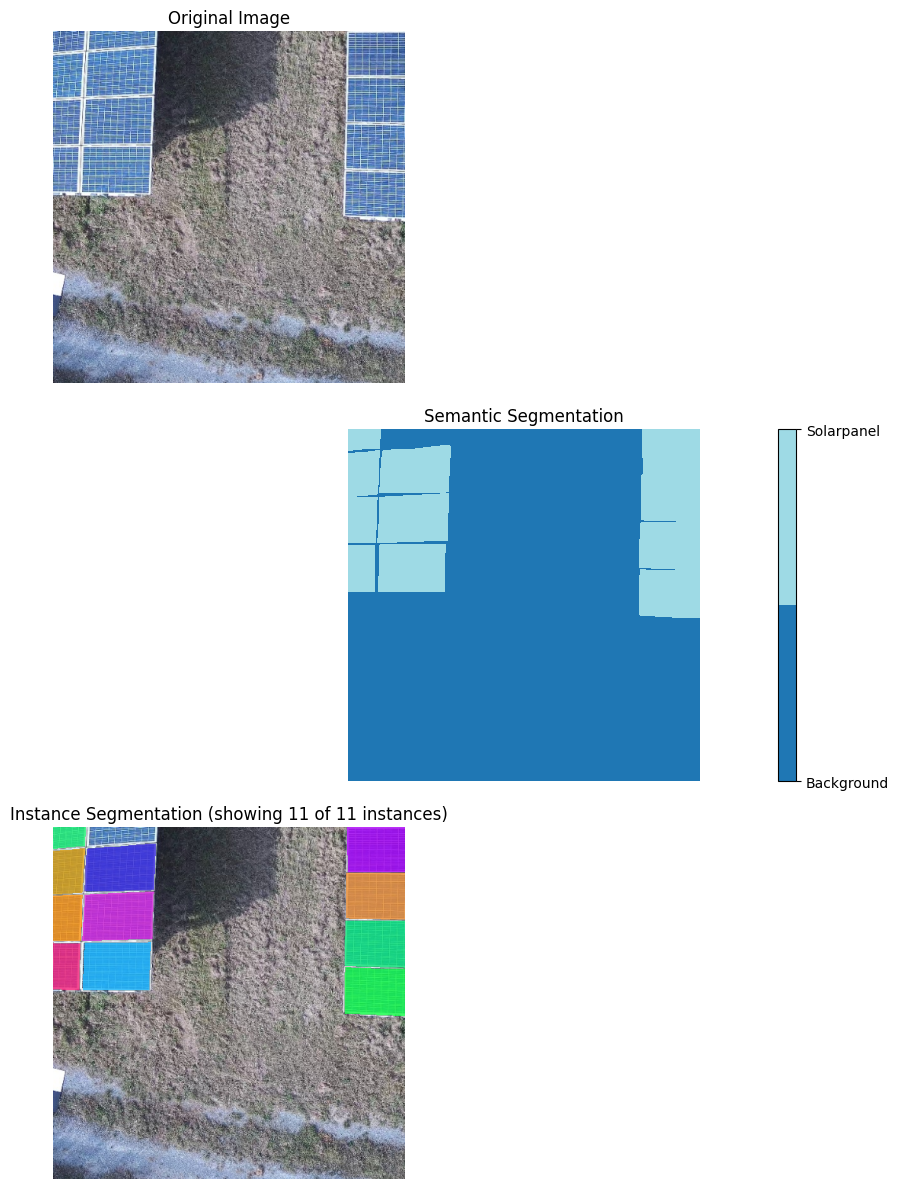

In [4]:
image_path = "../dataset/solarcoco/imgs"
mask_path = "../dataset/solarcoco/annotations/frame_000003.JSON"
instance_path = "../dataset/solarcoco/instance"


# Create dataset
dataset = COCOInstanceSegmentationDataset(
   coco_json_path = mask_path,
    img_dir = image_path,
    instance_dir = instance_path,
    transform=get_instance_transforms(img_size=args["img_size"], augment=True)

)


batch = next(iter(dataset))

# Visualize just the one-hot instances
fig = dataset.visualize_instance_segmentation(
    batch = batch,
    class_ids=[0,1],
    class_names= args["class_names"]
)

plt.show()



In [5]:

import torch
from torch.utils.data import Sampler
import numpy as np


class RepeatingBatchSampler(Sampler):
    """
    Sampler that repeats dataset indices to ensure each batch contains batch_size items.
    Useful when working with small datasets or when you want to apply heavy augmentation
    to a small set of samples.
    """
    def __init__(self, dataset_size, batch_size, shuffle=True):
        """
        Args:
            dataset_size: Number of samples in the original dataset
            batch_size: Desired batch size 
            shuffle: Whether to shuffle the data or access sequentially
        """
        self.dataset_size = dataset_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Number of copies needed for each dataset item
        self.copies_per_item = max(1, batch_size // dataset_size)
        
        # Extra samples needed beyond perfect division
        self.extra_samples = batch_size - (dataset_size * self.copies_per_item)
        if self.extra_samples < 0:
            self.extra_samples = 0
        
        # Total number of indices we'll generate
        self.total_samples = dataset_size * self.copies_per_item + self.extra_samples
        
    def __iter__(self):
        # Create base indices
        if self.shuffle:
            # For each "epoch", we shuffle the dataset order
            base_indices = torch.randperm(self.dataset_size).tolist()
        else:
            base_indices = list(range(self.dataset_size))
        
        # Repeat each index the required number of times
        repeated_indices = []
        for idx in base_indices:
            repeated_indices.extend([idx] * self.copies_per_item)
        
        # Add extra samples if needed to exactly reach batch_size
        if self.extra_samples > 0:
            extra_indices = base_indices[:self.extra_samples]
            repeated_indices.extend(extra_indices)
        
        # Shuffle the final indices to mix different samples
        if self.shuffle:
            np.random.shuffle(repeated_indices)
        
        return iter(repeated_indices)
    
    def __len__(self):
        return self.total_samples


from torch.utils.data._utils.collate import default_collate

def instance_segmentation_collate_fn(batch):
    """
    Custom collate function for instance segmentation datasets.
    
    Ensures all tensors have consistent dimensions across the batch:
    1. Creates placeholder instance masks for samples lacking them
    2. Ensures all instance-related tensors have the same count (boxes, masks, classes)
    3. Ensures tensors are in PyTorch's CHW format (not HWC)
    4. Ensures heatmaps have consistent dimensions
    
    Args:
        batch: List of samples from the dataset
        
    Returns:
        Batched dictionary with properly handled instance segmentation data
    """
    if not batch:
        return {}
    
    # Fix dimension ordering in each sample before collating
    for i, sample in enumerate(batch):
        # Check and fix RGB image tensor format
        if 'rgb' in sample and isinstance(sample['rgb'], torch.Tensor):
            # Check if the tensor looks like [H, W, C] format
            if (sample['rgb'].dim() == 3 and sample['rgb'].shape[2] == 3) or \
               (sample['rgb'].dim() == 4 and sample['rgb'].shape[3] == 3):
                # Convert from [H, W, C] to [C, H, W] or [B, H, W, C] to [B, C, H, W]
                if sample['rgb'].dim() == 3:
                    # [H, W, C] -> [C, H, W]
                    batch[i]['rgb'] = sample['rgb'].permute(2, 0, 1)
                else:
                    # [B, H, W, C] -> [B, C, H, W]
                    batch[i]['rgb'] = sample['rgb'].permute(0, 3, 1, 2)
                    
        # Fix centers format - ensure it has a channel dimension
        if 'centers' in sample and isinstance(sample['centers'], torch.Tensor):
            # If centers is 2D [H, W], add a channel dimension to make it [1, H, W]
            if sample['centers'].dim() == 2:
                batch[i]['centers'] = sample['centers'].unsqueeze(0)
    
    # Get sample keys from first sample
    first_sample = batch[0]
    all_keys = list(first_sample.keys())
    
    # Step 1: Determine the maximum number of instances (boxes, masks) across all samples
    max_instances = 0
    mask_height = 0
    mask_width = 0
    
    # First pass to find the maximum dimensions
    for sample in batch:
        # Check instance_masks shape
        if 'instance_masks' in sample and sample['instance_masks'] is not None:
            if isinstance(sample['instance_masks'], torch.Tensor) and sample['instance_masks'].dim() == 3:
                num_instances = sample['instance_masks'].size(0)
                mask_height = sample['instance_masks'].size(1)
                mask_width = sample['instance_masks'].size(2)
                max_instances = max(max_instances, num_instances)
        
        # Check boxes shape
        if 'boxes' in sample and sample['boxes'] is not None:
            if isinstance(sample['boxes'], torch.Tensor) and sample['boxes'].dim() == 2:
                num_instances = sample['boxes'].size(0)
                max_instances = max(max_instances, num_instances)
        
        # Check instance_classes shape
        if 'instance_classes' in sample and sample['instance_classes'] is not None:
            if isinstance(sample['instance_classes'], torch.Tensor) and sample['instance_classes'].dim() == 1:
                num_instances = sample['instance_classes'].size(0)
                max_instances = max(max_instances, num_instances)
    
    # If mask dimensions weren't found from instance_masks
    if mask_height == 0 or mask_width == 0:
        # Try to get dimensions from 'mask' field
        if 'mask' in first_sample and isinstance(first_sample['mask'], torch.Tensor):
            if first_sample['mask'].dim() == 2:  # [H, W] format
                mask_height, mask_width = first_sample['mask'].shape
            elif first_sample['mask'].dim() == 3:  # [C, H, W] or [H, W, C] format
                if first_sample['mask'].shape[0] <= 10:  # Likely [C, H, W]
                    mask_height, mask_width = first_sample['mask'].shape[1:]
                else:  # Likely [H, W, C]
                    mask_height, mask_width = first_sample['mask'].shape[:2]
        # Or use RGB image dimensions
        elif 'rgb' in first_sample and isinstance(first_sample['rgb'], torch.Tensor):
            if first_sample['rgb'].dim() == 3:  # [C, H, W] format
                mask_height, mask_width = first_sample['rgb'].shape[1:]
            elif first_sample['rgb'].dim() == 4:  # [B, C, H, W] format
                mask_height, mask_width = first_sample['rgb'].shape[2:]
        else:
            # Use a reasonable default
            mask_height, mask_width = 448, 448
    
    # Ensure at least one instance per sample
    max_instances = max(1, max_instances)
    
    # Step 2: Normalize all instance-related data to have the same instance count
    for i, sample in enumerate(batch):
        # Fix instance_masks
        if 'instance_masks' not in sample or sample['instance_masks'] is None:
            # Create an empty masks tensor
            batch[i]['instance_masks'] = torch.zeros((max_instances, mask_height, mask_width), 
                                                   dtype=torch.float32)
        else:
            # Pad or trim existing instance_masks
            curr_masks = sample['instance_masks']
            curr_instances = curr_masks.size(0)
            
            if curr_instances < max_instances:
                # Pad with empty masks
                padding = torch.zeros((max_instances - curr_instances, mask_height, mask_width),
                                    dtype=curr_masks.dtype,
                                    device=curr_masks.device)
                batch[i]['instance_masks'] = torch.cat([curr_masks, padding], dim=0)
            elif curr_instances > max_instances:
                # Trim to maximum instances
                batch[i]['instance_masks'] = curr_masks[:max_instances]
        
        # Fix instance_classes
        if 'instance_classes' not in sample or sample['instance_classes'] is None:
            # Create an empty classes tensor
            batch[i]['instance_classes'] = torch.zeros(max_instances, dtype=torch.long)
        else:
            # Pad or trim existing instance_classes
            curr_classes = sample['instance_classes']
            curr_instances = curr_classes.size(0)
            
            if curr_instances < max_instances:
                # Pad with zeros
                padding = torch.zeros(max_instances - curr_instances,
                                    dtype=curr_classes.dtype,
                                    device=curr_classes.device)
                batch[i]['instance_classes'] = torch.cat([curr_classes, padding], dim=0)
            elif curr_instances > max_instances:
                # Trim to maximum instances
                batch[i]['instance_classes'] = curr_classes[:max_instances]
        
        # Fix boxes
        if 'boxes' not in sample or sample['boxes'] is None:
            # Create an empty boxes tensor
            batch[i]['boxes'] = torch.zeros((max_instances, 4), dtype=torch.float32)
        else:
            # Pad or trim existing boxes
            curr_boxes = sample['boxes']
            curr_instances = curr_boxes.size(0)
            
            if curr_instances < max_instances:
                # Pad with zeros
                padding = torch.zeros((max_instances - curr_instances, 4),
                                    dtype=curr_boxes.dtype,
                                    device=curr_boxes.device)
                batch[i]['boxes'] = torch.cat([curr_boxes, padding], dim=0)
            elif curr_instances > max_instances:
                # Trim to maximum instances
                batch[i]['boxes'] = curr_boxes[:max_instances]
    
    # Step 3: Apply default_collate to batch with consistent dimensions
    result_batch = {}
    
    # Identify metadata keys that shouldn't be batched
    metadata_keys = ['img_id', 'file_name', 'metadata']
    
    # Process keys
    for key in all_keys:
        if key in metadata_keys:
            # Keep metadata in lists without batching
            result_batch[key] = [sample.get(key) for sample in batch]
        else:
            # Use default_collate for everything else (which should now have consistent shapes)
            try:
                values = [sample[key] for sample in batch if key in sample]
                if values:
                    result_batch[key] = default_collate(values)
                    
                    # Double-check image format after collating
                    if key == 'rgb' and isinstance(result_batch[key], torch.Tensor):
                        # Ensure RGB is in [B, C, H, W] format
                        if result_batch[key].dim() == 4 and result_batch[key].shape[3] == 3:
                            # It's in [B, H, W, C] format, permute to [B, C, H, W]
                            result_batch[key] = result_batch[key].permute(0, 3, 1, 2)
                    
                    # Ensure centers heatmap has channel dimension
                    if key == 'centers' and isinstance(result_batch[key], torch.Tensor):
                        # If centers is [B, H, W], add a channel dimension to make it [B, 1, H, W]
                        if result_batch[key].dim() == 3:
                            result_batch[key] = result_batch[key].unsqueeze(1)
            except Exception as e:
                # Fallback for any items that still can't be batched
                print(f"Warning: Could not batch {key}, keeping as list. Error: {e}")
                result_batch[key] = [sample.get(key) for sample in batch if key in sample]
    
    # Add helpful information for downstream processing
    result_batch['batch_size'] = len(batch)
    result_batch['num_instances'] = max_instances
    
    return result_batch

In [6]:
sampler = RepeatingBatchSampler(dataset_size=len(dataset),batch_size=args["batch_size"],
    shuffle=True
)
collate_fn = instance_segmentation_collate_fn
# Create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=args["batch_size"], 
    num_workers=0,
    # Use 0 for single image to avoid overhead,
    sampler = sampler,
    collate_fn = collate_fn,
    drop_last= True


)


In [7]:
# Create progress bar callback
from pytorch_lightning.callbacks import RichProgressBar
class LossProgressBar(RichProgressBar):
    def __init__(self):
        super().__init__()
        self.losses = []
        
    def on_train_epoch_end(self, trainer, pl_module):
        super().on_train_epoch_end(trainer, pl_module)
        loss = float(trainer.callback_metrics.get('train_total_loss', 0))
        self.losses.append(loss)
        
progress_bar = LossProgressBar()

# Create model checkpoint callback
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='train_total_loss',
    filename='pasiphae-upernet-{epoch:02d}-{train_total_loss:.4f}',
    save_top_k=1,
    mode='min'
)

# Early stopping callback
early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='train_total_loss',
    patience=50,
    mode='min'
)

# Create trainer
trainer = pl.Trainer(
    max_epochs=200,
    devices=1,
    callbacks=[progress_bar, checkpoint_callback, early_stop_callback],
    logger=True,
    log_every_n_steps=1,
    accelerator = "cuda"
)

# Train model
print("Starting training...")
trainer.fit(pl_model, dataloader)

print("Training complete!")




GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                   ┃ Type                              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                  │ MSRGBConvNeXtInstanceSegmentation │  117 M │ train │
│ 1 │ semantic_criterion     │ CrossEntropyLoss                  │      0 │ train │
│ 2 │ center_criterion       │ BCELoss                           │      0 │ train │
│ 3 │ instance_cls_criterion │ CrossEntropyLoss                  │      0 │ train │
│ 4 │ mask_criterion         │ BCEWithLogitsLoss                 │      0 │ train │
└───┴────────────────────────┴───────────────────────────────────┴────────┴───────┘

Trainable params: 32.3 M                                                                                           
Non-trainable params: 85.3 M                                                                                       
Total params: 117 M                                                                                                
Total estimated model params size (MB): 470                                                                        
Modules in train mode: 546                                                                                         
Modules in eval mode: 0

Output()

C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


C:\Users\judoj\mambaforge\envs\lightly\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer 
the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use 
`self.log(..., batch_size=batch_size)`.

`Trainer.fit` stopped: `max_epochs=200` reached.


Training complete!


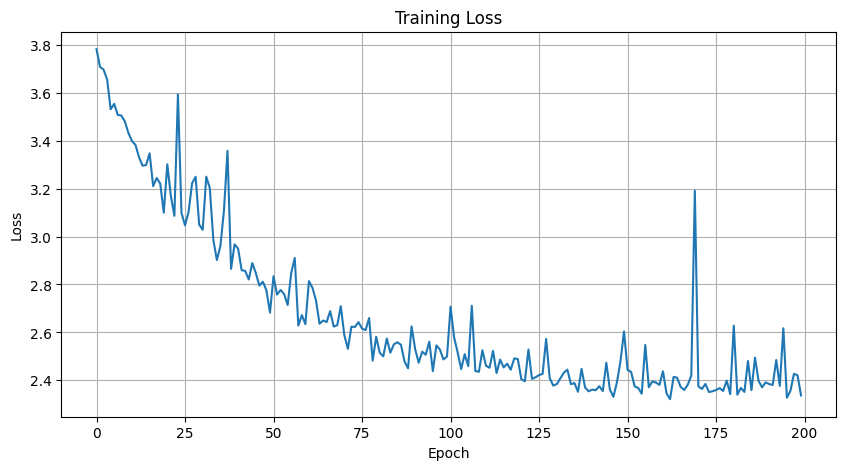

In [9]:
# Plot loss curve
losses = progress_bar.losses
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [12]:
# Apply to dataset:
# Create train/val/test datasets
rgb_transform = transforms.Compose([
    transforms.Resize((args["img_size"],args["img_size"] ), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])


solar_folder = "../dataset/pvhawk" 

non_labeled = LightlyDataset(input_dir = "../dataset/pvhawk",transform=rgb_transform)
non_labeled = torch.utils.data.DataLoader(non_labeled)

In [17]:
# Process all images
from tqdm import tqdm

device='cuda'
pl_model.to(device)
all_results = []

pl_model.eval()

for rgb, idx, img_name in tqdm(iter(non_labeled)):
    rgb = rgb.to(device)
    
    with torch.no_grad():
        outputs = pl_model(rgb  = rgb)
        # Get semantic segmentation prediction
    pred_mask = torch.argmax(outputs["sem_logits"], dim=1).cpu().numpy()
    
    # Get instance masks if available
    if 'mask_coeffs' in outputs:

        # If mask_coeffs are already in mask format
        instance_masks = outputs['mask_coeffs']
        
        # Convert to numpy for saving
        instance_masks = instance_masks.cpu().numpy()
    else:
        instance_masks = None
    
    # Get instance boxes if available
    instance_boxes = outputs.get('boxes', None)
    if instance_boxes is not None:
        instance_boxes = instance_boxes.cpu().numpy()
    
    # Get instance classes if available
    instance_classes = outputs.get('cls_scores', None)
    if instance_classes is not None:
        # Get the predicted class for each instance
        if instance_classes.dim() > 2:  # If shape is [B, N, C]
            instance_class_ids = torch.argmax(instance_classes, dim=2).cpu().numpy()
        else:
            instance_class_ids = torch.argmax(instance_classes, dim=1).cpu().numpy()
    else:
        instance_class_ids = None
    
    # Get center heatmap if available
    if 'center_heatmap' in outputs:
        center_heatmap = outputs['center_heatmap'].cpu().numpy()
    else:
        center_heatmap = None
    
    # Convert tensor back to PIL image for visualization
    orig_img = rgb.cpu().squeeze(0)
    # Denormalize if needed
    orig_img = torch.clamp(orig_img, 0, 1)
    
    # Store all results together
    all_results.append({
        'image': orig_img.permute(1, 2, 0).numpy(),  # Convert to HWC format for visualization
        'mask': pred_mask[0],  # Semantic segmentation mask
        'instance_masks': instance_masks[0] if instance_masks is not None else None,  # Instance masks
        'instance_boxes': instance_boxes[0] if instance_boxes is not None else None,  # Bounding boxes
        'instance_classes': instance_class_ids[0] if instance_class_ids is not None else None,  # Class IDs
        'center_heatmap': center_heatmap[0] if center_heatmap is not None else None,  # Center points
        'filename': img_name[0] if isinstance(img_name, list) else img_name
    })
    

    



 70%|████████████████████████████████████████████████████████                        | 345/492 [01:06<00:28,  5.20it/s]


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR_HOST_ALLOCATION_FAILED

In [19]:
num_samples=10
import random
# Sample random images
if len(all_results) > num_samples:
    random_samples = random.sample(all_results, num_samples)
else:
    random_samples = all_results

C:\Users\judoj\AppData\Local\Temp\ipykernel_53796\3734175274.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_colors)


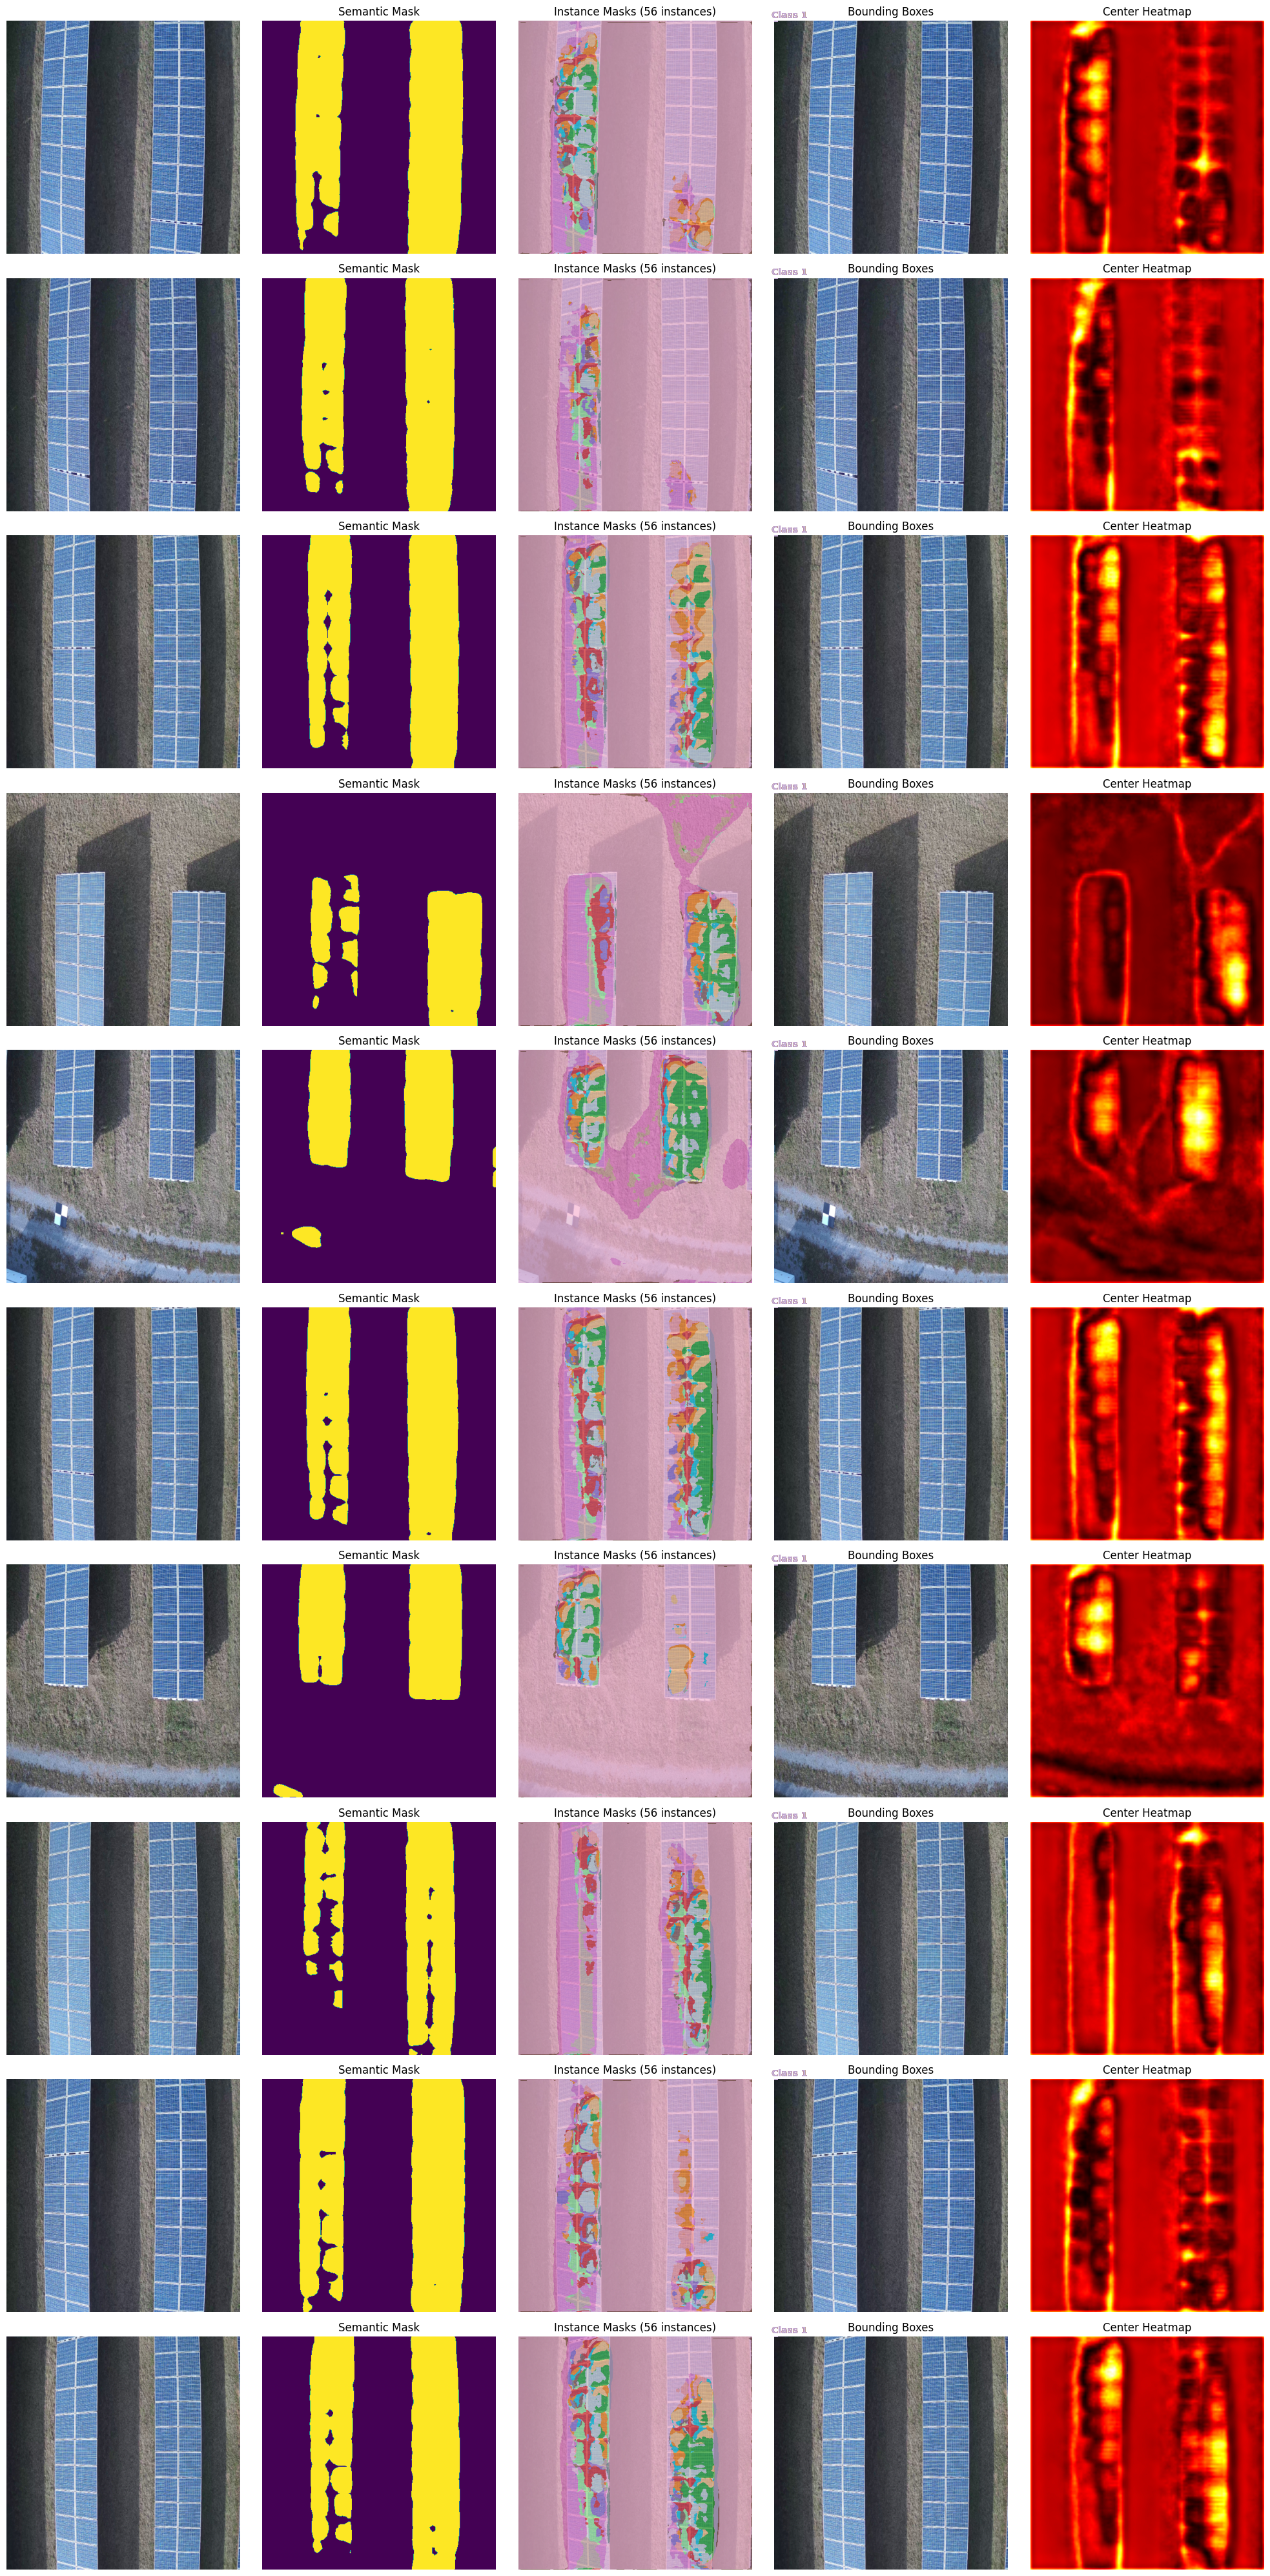

Visualization saved to segmentation_results.png


In [21]:
# Visualize the results
def visualize_segmentation(samples, save_path='segmentation_results.png'):
    """
    Visualize segmentation results including original image, semantic segmentation mask,
    instance masks, and bounding boxes.
    
    Args:
        samples: List of dictionaries containing results for each sample
        save_path: Path to save the visualization
    """
    # Determine the number of columns - add columns for instance segmentation if available
    num_cols = 2  # Default: Original image + semantic mask
    
    # Check if we have instance masks
    has_instances = any(sample.get('instance_masks') is not None for sample in samples)
    has_boxes = any(sample.get('instance_boxes') is not None for sample in samples)
    has_centers = any(sample.get('center_heatmap') is not None for sample in samples)
    
    if has_instances:
        num_cols += 1  # Add column for instance masks
    if has_boxes:
        num_cols += 1  # Add column for box visualization
    if has_centers:
        num_cols += 1  # Add column for center heatmap
    
    # Create figure
    fig, axes = plt.subplots(len(samples), num_cols, figsize=(4*num_cols, 4*len(samples)))
    
    # If only one sample, wrap axes in a list
    if len(samples) == 1:
        axes = [axes] if num_cols == 1 else [axes]
    
    # Create colormap for instances
    from matplotlib.colors import ListedColormap
    import matplotlib as mpl
    
    # Generate distinct colors for instance visualization
    num_colors = 20  # Arbitrary, could be increased
    cmap = plt.cm.get_cmap('tab20', num_colors)
    colors = [cmap(i) for i in range(num_colors)]
    
    # Process each sample
    for i, sample in enumerate(samples):
        col_idx = 0
        
        # Original image
        axes[i][col_idx].imshow(sample['image'])
        #axes[i][col_idx].set_title(f"Original: {os.path.basename(sample['filename'])}")
        axes[i][col_idx].axis('off')
        col_idx += 1
        
        # Semantic segmentation mask
        sem_mask = sample['mask']
        num_classes = len(np.unique(sem_mask))
        
        # Create a more visually distinct colormap for semantic classes
        if num_classes <= 2:  # Binary mask
            axes[i][col_idx].imshow(sem_mask, cmap='viridis')
        else:  # Multi-class mask
            axes[i][col_idx].imshow(sem_mask, cmap='nipy_spectral')
            
        axes[i][col_idx].set_title(f"Semantic Mask")
        axes[i][col_idx].axis('off')
        col_idx += 1
        
        # Instance segmentation visualization
        if has_instances and sample.get('instance_masks') is not None:
            instance_masks = sample['instance_masks']
            num_instances = instance_masks.shape[0]
            
            # Create a visualization with each instance in a different color
            instance_vis = np.zeros((*sem_mask.shape, 3), dtype=np.float32)
            
            for inst_idx in range(num_instances):
                # Get color for this instance
                color = colors[inst_idx % num_colors][:3]
                
                # Create mask for this instance (threshold at 0.5 if not binary)
                mask = instance_masks[inst_idx] > 0.5 if isinstance(instance_masks[inst_idx].max(), (int, float)) else instance_masks[inst_idx] > 0
                
                # Skip empty masks
                if not np.any(mask):
                    continue
                
                # Add this instance with its color
                for c in range(3):
                    instance_vis[:, :, c] = np.where(mask, 
                                                   color[c], 
                                                   instance_vis[:, :, c])
            
            # Overlay instances on the image with alpha blending
            overlay = sample['image'].copy()
            alpha = 0.7  # Transparency for the instance masks
            
            # Only apply alpha blending where masks exist
            any_mask = np.any(instance_vis > 0, axis=2)
            for c in range(3):
                overlay[:, :, c] = np.where(any_mask, 
                                          overlay[:, :, c] * (1 - alpha) + instance_vis[:, :, c] * alpha,
                                          overlay[:, :, c])
            
            axes[i][col_idx].imshow(overlay)
            axes[i][col_idx].set_title(f"Instance Masks ({num_instances} instances)")
            axes[i][col_idx].axis('off')
            col_idx += 1
        
        # Bounding box visualization
        if has_boxes and sample.get('instance_boxes') is not None:
            boxes = sample['instance_boxes']
            
            # Create a copy of the original image for box visualization
            box_vis = sample['image'].copy()
            
            # Draw rectangles
            from matplotlib.patches import Rectangle
            
            # Display the image
            axes[i][col_idx].imshow(box_vis)
            
            # Draw each box
            for box_idx, box in enumerate(boxes):
                x1, y1, x2, y2 = box
                
                # If boxes are normalized to 0-1, scale to image dimensions
                if x1 <= 1.0 and y1 <= 1.0 and x2 <= 1.0 and y2 <= 1.0:
                    h, w = box_vis.shape[:2]
                    x1, y1, x2, y2 = x1 * w, y1 * h, x2 * w, y2 * h
                
                # Get color for this box
                color = colors[box_idx % num_colors]
                
                # Create rectangle
                rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                                linewidth=2, edgecolor=color, facecolor='none')
                axes[i][col_idx].add_patch(rect)
                
                # Add class label if available
                if sample.get('instance_classes') is not None:
                    class_id = sample['instance_classes'][box_idx]
                    axes[i][col_idx].text(x1, y1-5, f"Class {class_id}", 
                                        color=color, fontsize=10, weight='bold')
            
            axes[i][col_idx].set_title(f"Bounding Boxes")
            axes[i][col_idx].axis('off')
            col_idx += 1
        
        # Center heatmap visualization
        if has_centers and sample.get('center_heatmap') is not None:
            heatmap = sample['center_heatmap']
            
            # Handle different heatmap formats
            if heatmap.ndim > 2:
                if heatmap.shape[0] == 1:  # [1, H, W]
                    heatmap = heatmap[0]
                elif heatmap.ndim == 4 and heatmap.shape[0] == 1 and heatmap.shape[1] == 1:  # [1, 1, H, W]
                    heatmap = heatmap[0, 0]
            
            # Normalize heatmap for visualization
            if heatmap.max() > 0:
                heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
            else:
                heatmap_norm = heatmap
            
            # Show heatmap with a red-yellow colormap
            axes[i][col_idx].imshow(heatmap_norm, cmap='hot')
            axes[i][col_idx].set_title("Center Heatmap")
            axes[i][col_idx].axis('off')
            col_idx += 1
    
    plt.tight_layout()
    ##plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Visualization saved to {save_path}")

visualize_segmentation(random_samples)

In [ ]:


output_path = "model_trained_on_single_image.pth"
torch.save(model.state_dict(), output_path)
print(f"Model saved to {output_path}")
